# Self Corrective RAG (CRAG) with LangGraph

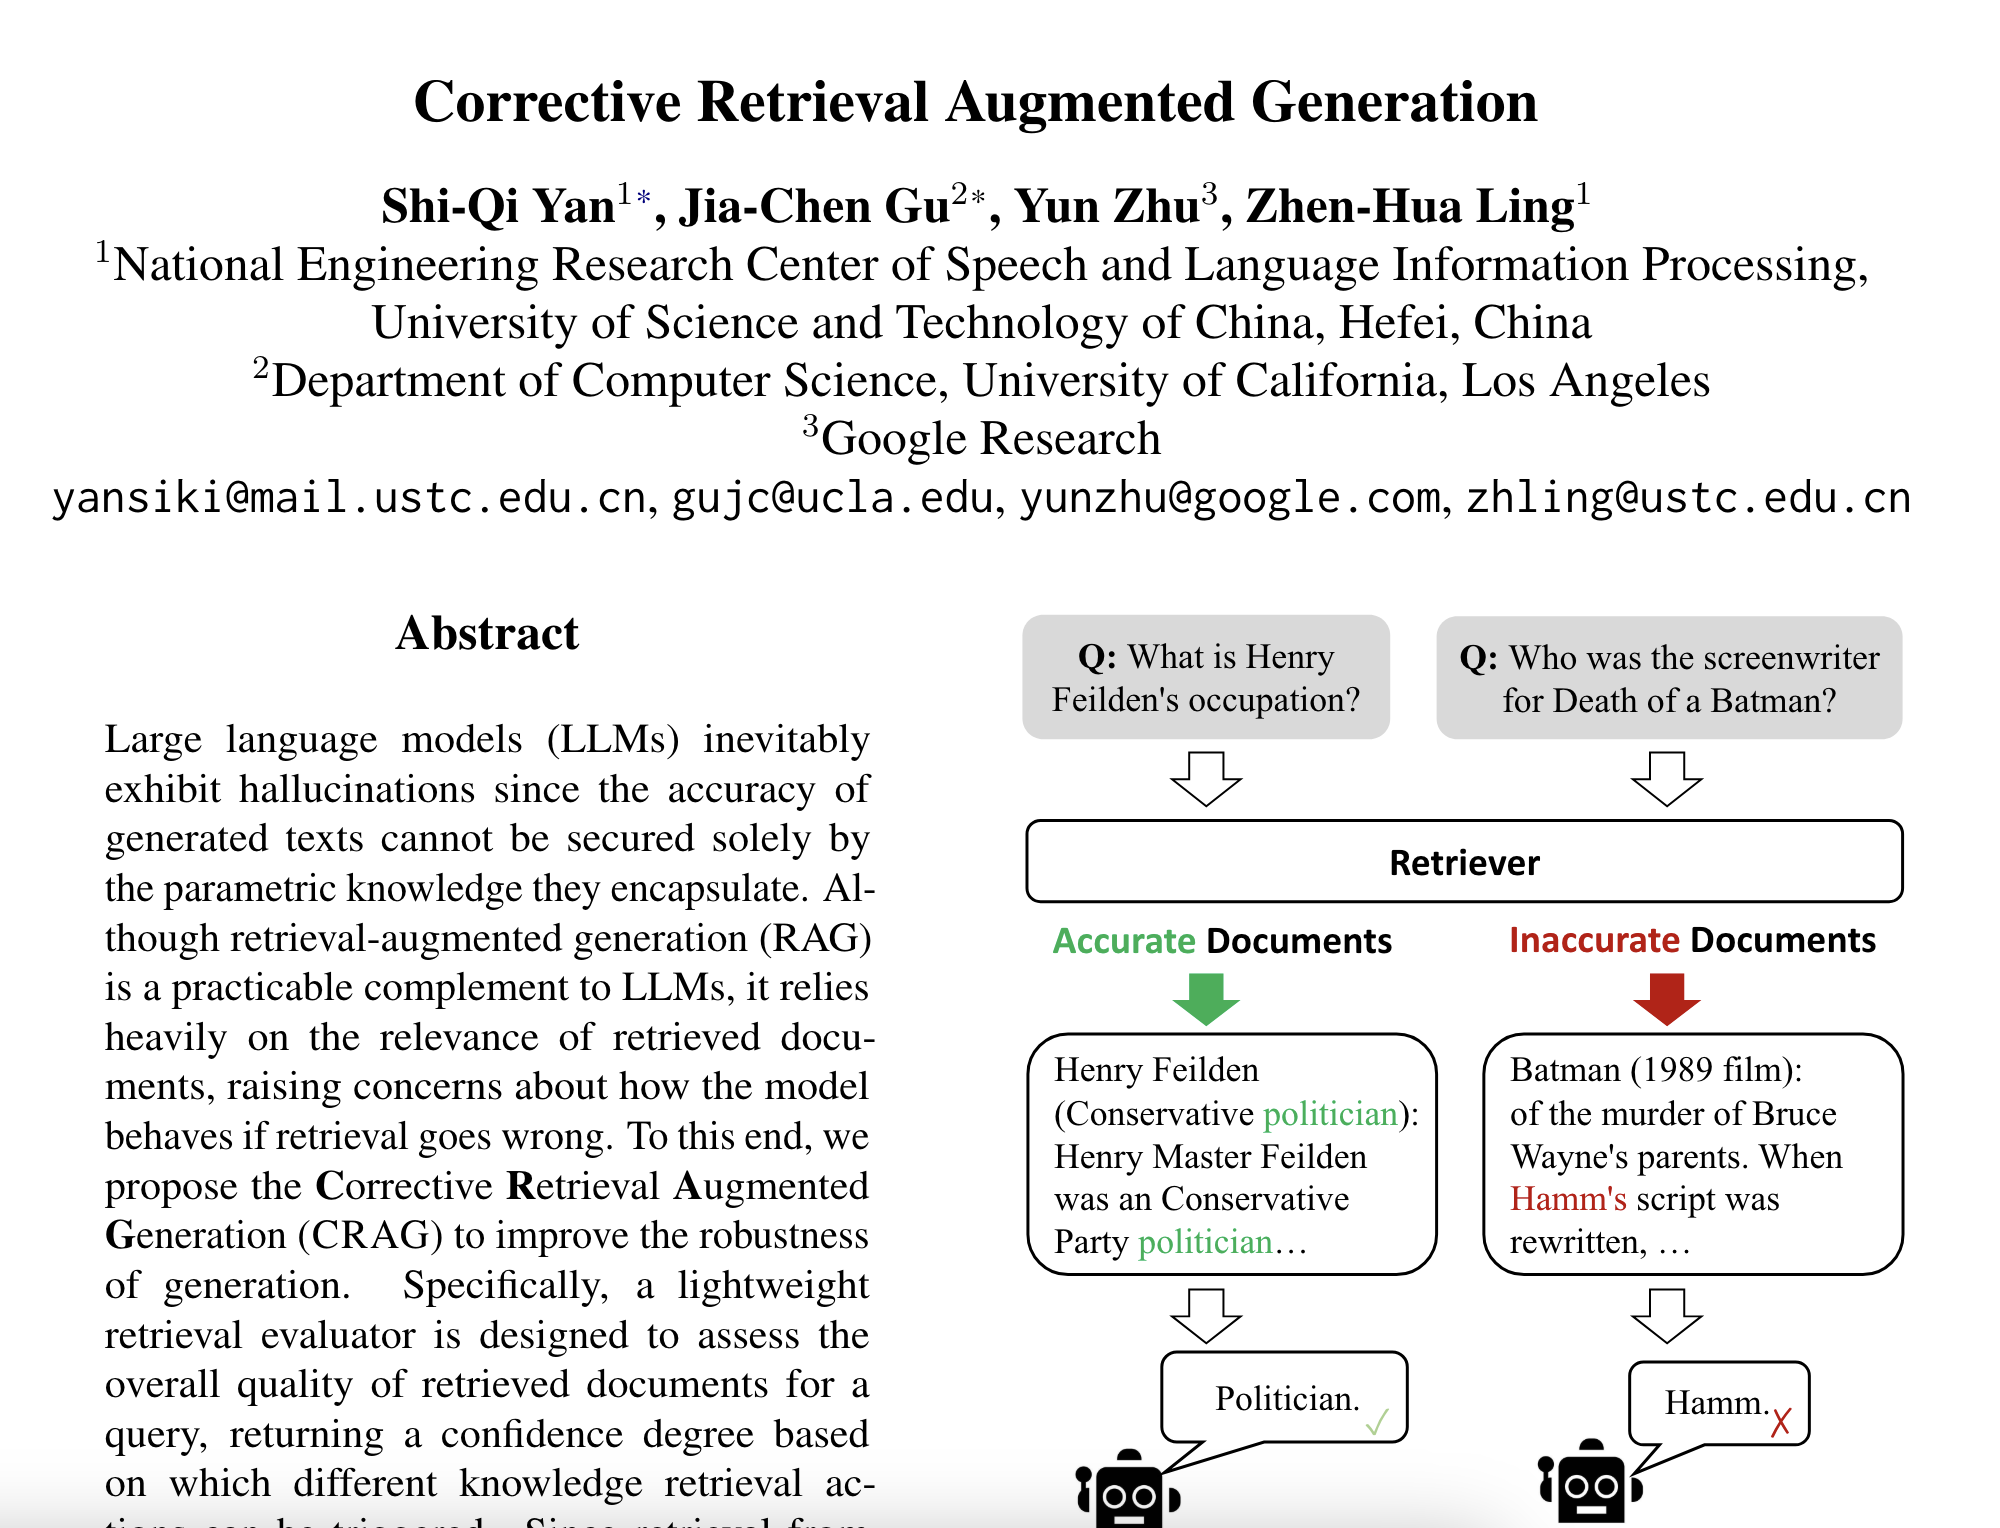

In [50]:
from IPython.display import Image
Image(filename='Images/CRAG.png',width=900)

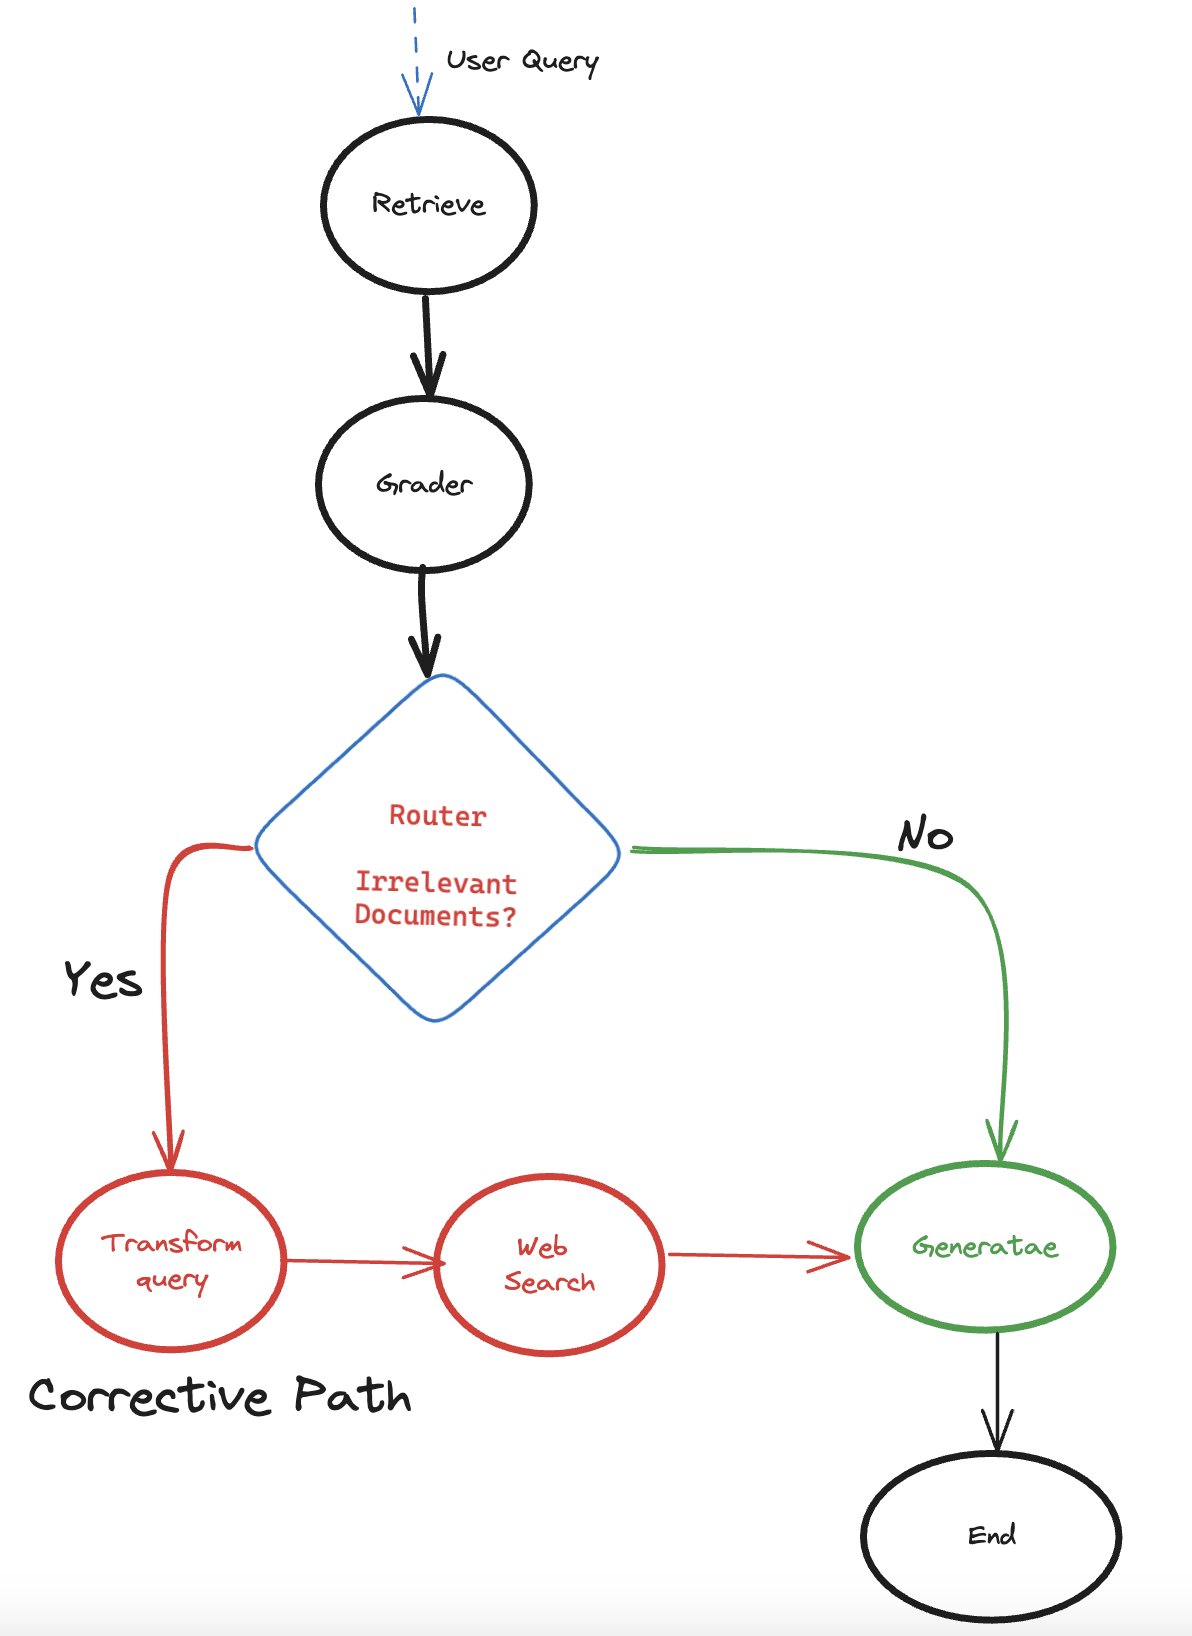

In [52]:
from IPython.display import Image
Image(filename='Images/CRAG_LG.png',width=600)

### Populate Vector DB and create Retriever

In [1]:
from utils.build_rag import RAG

In [2]:
rag = RAG()
rag.populate_vector_db()

/Users/aritra.sen/Aritra/coding/my_llm_app/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/aritra.sen/Aritra/coding/my_llm_app/.venv/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/Users/aritra.sen/Aritra/coding/my_llm_app/.venv/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/Users/aritra.sen/Aritra/coding/my_llm_app/.venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationW

In [3]:
retriever = rag.get_retriever()

### Initializing the keys

In [4]:
import os
from dotenv import load_dotenv

load_dotenv()


from langchain_openai import ChatOpenAI

# Now you can access your environment variables using os.environ
os.environ['OPENAI_API_KEY'] = os.environ.get("OPENAI_API_KEY")
os.environ['TAVILY_API_KEY'] = os.environ.get("TAVILY_API_KEY")


llm = ChatOpenAI(model="gpt-4-1106-preview")

### Retrieval Grader

In [5]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

/Users/aritra.sen/Aritra/coding/my_llm_app/.venv/lib/python3.10/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The method `ChatOpenAI.with_structured_output` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


In [35]:
question = "Tell me about LLama2"

docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(doc_txt)

print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

-80GB (TDP of 350-400W). Estimated total emissions were 539
tCO 2eq, 100% of which were offset by Meta’s sustainability program.
Training Data (Sections 2.1 and 3)
Overview Llama 2 was pretrained on 2 trillion tokens of data from publicly available
sources. The fine-tuning data includes publicly available instruction datasets, as
wellasoveronemillionnewhuman-annotatedexamples. Neitherthepretraining
nor the fine-tuning datasets include Meta user data.
Data Freshness The pretraining data has a cutoff of September 2022, but some tuning data is
more recent, up to July 2023.
Evaluation Results
See evaluations for pretraining (Section 2); fine-tuning (Section 3); and safety (Section 4).
Ethical Considerations and Limitations (Section 5.2)
Llama 2 is a new technology that carries risks with use. Testing conducted to date has been in
English, and has notcovered, nor could it coverall scenarios. For these reasons, aswith all LLMs,
Llama 2’s potential outputs cannot be predicted in advance, and 

In [38]:
question1 = "Tell me about LLama3"

docs1 = retriever.invoke(question1)
doc_txt = docs1[1].page_content
print(doc_txt)

print(retrieval_grader.invoke({"question": question1, "document": doc_txt}))

Figure 3: Safety human evaluation results for Llama 2-Chat compared to other open-source and closed-
source models. Human raters judged model generations for safety violations across ~2,000 adversarial
prompts consisting of both single and multi-turn prompts. More details can be found in Section 4.4. It is
importanttocaveatthesesafetyresultswiththeinherentbiasofLLMevaluationsduetolimitationsofthe
promptset,subjectivityofthereviewguidelines,andsubjectivityofindividualraters. Additionally,these
safety evaluations are performed using content standards that are likely to be biased towards the Llama
2-Chatmodels.
We are releasing the following models to the general public for research and commercial use‡:
1.Llama 2 ,anupdatedversionof Llama 1,trainedonanewmixofpubliclyavailabledata. Wealso
increasedthesizeofthepretrainingcorpusby40%,doubledthecontextlengthofthemodel,and
adoptedgrouped-queryattention(Ainslieetal.,2023). Wearereleasingvariantsof Llama 2 with
7B,13B,and70Bparameters. Wehaveals

### Generator

In [31]:
from langchain_core.runnables import RunnablePassthrough
from langchain.chains import RetrievalQA
from langchain_core.output_parsers import StrOutputParser


template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

rag_chain = prompt | llm | StrOutputParser()


In [39]:
generation = rag_chain.invoke({"context": docs, "question": question})

print(generation)

Llama 2 is a language model that has been pretrained on a vast dataset consisting of 2 trillion tokens from publicly available sources. The model has also gone through a fine-tuning process using publicly available instruction datasets, as well as over one million new human-annotated examples. Importantly, the datasets used for both the pretraining and the fine-tuning of Llama 2 do not include any user data from Meta.

The pretraining data for Llama 2 has a cutoff of September 2022, meaning that no data beyond this date was included in the initial training phase. However, the model has been updated with some tuning data that is more recent, extending up to July 2023.

Regarding its environmental impact, Llama 2 has a thermal design power (TDP) between 350-400 watts and the estimated total emissions from its operation were 539 metric tonnes of CO2 equivalent. These emissions have been fully offset by Meta's sustainability program, which aligns with environmental responsibility efforts.


### Question Re-writer

In [13]:
# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

### Web Search Tool

In [14]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=2)

### Graph Creation

In [21]:
from typing_extensions import TypedDict
from typing import List


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

In [40]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}

### Edge Router

In [41]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

### Build Graphs

In [42]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

### Testing with questions

In [43]:
from pprint import pprint

# Run
inputs = {"question": "What is Llama2?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")

    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('Llama 2 is a language model that was pretrained on 2 trillion tokens of data '
 'from publicly available sources. It has been further fine-tuned with '
 'publicly available instruction datasets and over one million new '
 'human-annotated examples. The document indicates that Llama 2 is a new '
 'technology with potential risks associated with its use, and it has been '
 'primarily tested in English. Since its potential outputs cannot be fully '
 'predicted, developers are advised to perform safety testing and tuning for '
 'their specific applications before deploying Llama 2. The model does not '
 'include Meta user data in its pretraining or

In [44]:
inputs = {"question": "What is Llama3?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")

    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('Llama 3 is a text-generation AI capable of handling a wide range of tasks, '
 'including text, image, and video processing. It was trained on a dataset of '
 'more than 15 trillion tokens, which is seven times larger than the dataset '
 'used for its predecessor, Llama 2. This extensive training enables Llama 3 '
 'to have a more nuanced understanding and generation of content.\n'
 '\n'
 'Key features and capabilities of Llama 3 include:\n'
 '\n'
 "- Text generation: Si